<a id='home'></a>
### purpose

train lfmm nuisance


### notes

- MVP_11_validate_lfmm2_offset.py was updated to exit after `calculate_performance` in `main` to avoid errors from figures
- failed jobs were jumpstarted in the normal jumpstart directory

In [1]:
from pythonimports import *

import MVP_summary_functions as mvp
import MVP_10_train_lfmm2_offset as mvp10

run = '0-225'

nuis_outerdirs = {
    'ISO-PSsd' : f'/home/b.lind/offsets/run_20220919_nuisance/ISO-PSsd_{run}',
    'ISO-TSsd-PSsd' : f'/home/b.lind/offsets/run_20220919_nuisance/ISO-TSsd-PSsd_{run}'
}

lfmm_dirs = {}
for nuis_envs, outerdir in nuis_outerdirs.items():
    lfmm_dirs[nuis_envs] = makedir(f'{outerdir}/lfmm2')
    
old_outerdir = f'/home/b.lind/offsets/run_20220919_{run}'

lview, dview = get_client(cluster_id='1687360014-lvhz', profile='lotterhos')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	June 21, 2023 - 13:49:02 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit eb8d204ff9a40e48b07c184bcc4ff8621804cde6  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu Jun 15 14:34:48 2023 -0400

Current commit of MVP_offsets:
commit 024290cb8c961841537c81afd1a02917b24bc9af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Jun 12 10:46:56 2023 -0400
#########################################################



# symlink input genotype files

In [2]:
old_slimdir = f'{old_outerdir}/slimdir'
genofiles = fs(old_slimdir, endswith='_genotypes.lfmm')

assert len(genofiles) == 225

In [3]:
for nuis_envs, outerdir in nuis_outerdirs.items():
    slimdir = f'{outerdir}/slimdir'  # already exists from other runs
    
    for src in genofiles:
        real_src = op.realpath(src)
        basename = op.basename(real_src)
        
        dst = f'{slimdir}/{basename}'
        
        if not op.exists(dst):
            os.symlink(real_src, dst)

# symlink the temp RDS files

from Katie's output, used to find K for lfmm::genetic.offset

In [4]:
old_slimdir = f'{old_outerdir}/slimdir'
temp_files = fs(old_slimdir, endswith='_lfmm2_temp.RDS')

assert len(temp_files) == 225

In [5]:
for nuis_envs, outerdir in nuis_outerdirs.items():
    slimdir = f'{outerdir}/slimdir'  # already exists from other runs
    
    for src in temp_files:
        real_src = op.realpath(src)
        basename = op.basename(real_src)
        
        dst = f'{slimdir}/{basename}'
        
        if not op.exists(dst):
            os.symlink(real_src, dst)

# create envfiles

In [6]:
for nuis_envs, outerdir in nuis_outerdirs.items():
    slimdir = f'{outerdir}/slimdir'
    indir = makedir(f'{outerdir}/lfmm2/lfmm_infiles')
    
    # pseudo subset files created in 02.07.02_nuisance_envs.02_fit_and_validate_GF_nuis_envs.ipynb
    envfiles = fs(slimdir, endswith='Rout_ind_subset.txt')
    
    envs = ['sal_opt', 'temp_opt'] + nuis_envs.split('-')
    num_envs = len(envs)
    
    for f in pbar(envfiles, desc='-'.join(envs)):
        seed = op.basename(f).split("_")[0]
        
        # get the real subset file that has 1000 lines (one per individual)
        real_subset = pd.read_table(
            f'{old_outerdir}/slimdir/{seed}_Rout_ind_subset.txt',
            delim_whitespace=True
        )[['subpopID', 'indID']]
        
        # get the pseudo subset file with only 100 lines (one per pop)
        subset = pd.read_table(f, index_col=0)
        
        # add in pop-level env info that matches indID's subpopID
        for env in envs:
            envdict = dict(zip(subset.subpopID, subset[env]))
            real_subset[env] = real_subset.subpopID.map(envdict)
        
        # save only the env columns
        lfmm_envfile = f'{indir}/{seed}_lfmm_env_ntraits-{num_envs}.txt'
        real_subset[envs].to_csv(lfmm_envfile, sep='\t', index=False, header=False)
    
real_subset[envs]

sal_opt-temp_opt-ISO-TSsd-PSsd: 100%|███████████████| 225/225 [00:06<00:00, 36.27it/s]


,sal_opt,temp_opt,ISO,TSsd,PSsd
8,-1.0,-1.0,0.009381,-2.245441,1.003559
13,-1.0,-1.0,0.009381,-2.245441,1.003559
14,-1.0,-1.0,0.009381,-2.245441,1.003559
20,-1.0,-1.0,0.009381,-2.245441,1.003559
21,-1.0,-1.0,0.009381,-2.245441,1.003559
...,...,...,...,...,...
256,-1.0,1.0,1.137857,3.232988,2.967515
257,-1.0,1.0,1.137857,3.232988,2.967515
258,-1.0,1.0,1.137857,3.232988,2.967515
259,-1.0,1.0,1.137857,3.232988,2.967515


# create future envfiles

In [7]:
def create_future_file(f, slimdir, indir, envs, num_envs, old_outerdir, outerdir):
    """For a seeds envdata, `f` create future common garden data."""
    from pythonimports import nrow
    import pandas as pd
    from os import path as op
    
    seed = op.basename(f).split("_")[0]

    # get the real subset file that has 1000 lines (one per individual)
    real_subset = pd.read_table(f'{old_outerdir}/slimdir/{seed}_Rout_ind_subset.txt',
                                delim_whitespace=True)

    envdata = pd.read_table(f, index_col=0)
    envdata.index = envdata.subpopID.tolist()

    new_envfiles = []
    for subpopID in envdata.index:
        # get env values for this pop
        vals = envdata.loc[subpopID, envs]

        # create a dataframe where all vals are repeated for each individual
        df = pd.concat(
            [pd.DataFrame(vals).T for i in range(nrow(real_subset))]
        ).reset_index(drop=True)

        assert df.shape == (nrow(real_subset), num_envs)

        # save
        pop = str(subpopID).zfill(3)
        lfmm_envfile_new = f'{outerdir}/lfmm2/lfmm_infiles/{seed}_lfmm_env_ntraits-{num_envs}_{pop}.txt'
        df.to_csv(lfmm_envfile_new, sep='\t', index=False, header=False)

        new_envfiles.append(lfmm_envfile_new)
        
    return new_envfiles

In [8]:
jobs = []
all_args = []
for nuis_envs, outerdir in nuis_outerdirs.items():
    slimdir = f'{outerdir}/slimdir'
    indir = makedir(f'{outerdir}/lfmm2/lfmm_infiles')
    
    # pseudo subset files created in 02.07.02_nuisance_envs.02_fit_and_validate_GF_nuis_envs.ipynb
    envfiles = fs(slimdir, endswith='Rout_ind_subset.txt')
    
    # total number of envs
    envs = ['sal_opt', 'temp_opt'] + nuis_envs.split('-')
    num_envs = len(envs)
    
    for f in pbar(envfiles, desc='-'.join(envs)):
        args = (f, slimdir, indir, envs, num_envs, old_outerdir, outerdir)
        all_args.append(args)
        
        jobs.append(
            lview.apply_async(
                create_future_file, *args
            )
        )
    
watch_async(jobs)

sal_opt-temp_opt-ISO-TSsd-PSsd: 100%|███████████████| 225/225 [00:00<00:00, 808.80it/s]



Watching 450 jobs ...


 94%|██████████████▏| 424/450 [07:48<00:28,  1.11s/it]


KeboardInterrupted


In [12]:
# gather lists of future envfiles by nuis_envs and seed
new_envfiles = defaultdict(dict)
for i, j in enumerate(jobs):
    f, *_, envs, num_envs, old_outerdir, outerdir = all_args[i]
    
    seed = op.basename(f).split("_")[0]
    
    nuis_envs = '-'.join(envs[2:])
    new_envfiles[nuis_envs][seed] = j.r
    
    # make sure everything makes sense
    assert len(new_envfiles[nuis_envs][seed]) == 100
    assert luni(new_envfiles[nuis_envs][seed]) == 100  # 100 unique file names
    
    
# make sure everything makes sense
for nuis_envs, seed_dict in new_envfiles.items():
    assert len(seed_dict) == 225
    assert len(flatten(seed_dict.values())) == 22500  # 22500 unique file names (100 per seed * 225 seeds)

# symlink poplabels files

In [13]:
poplabel_files = fs(f'{old_outerdir}/lfmm2/lfmm_infiles', pattern='poplabel')

assert len(poplabel_files) == 225

for nuis_envs, outerdir in nuis_outerdirs.items():
    for src in pbar(poplabel_files, desc=nuis_envs):
        basename = op.basename(src)
        dst = f'{outerdir}/lfmm2/lfmm_infiles/{basename}'

        if not op.exists(dst):
            os.symlink(src, dst)

ISO-TSsd-PSsd: 100%|███████████████| 225/225 [00:00<00:00, 4551.09it/s]


# symlink adaptive and neutral marker sets

In [14]:
loci_files = fs(f'{old_outerdir}/lfmm2/lfmm_infiles', pattern='loci')

assert len(loci_files) == 450  # (adaptive + neut * 225)

for nuis_envs, outerdir in nuis_outerdirs.items():
    for src in pbar(loci_files, desc=nuis_envs):
        basename = op.basename(src)
        dst = f'{outerdir}/lfmm2/lfmm_infiles/{basename}'

        if not op.exists(dst):
            os.symlink(src, dst)

ISO-TSsd-PSsd: 100%|███████████████| 450/450 [00:00<00:00, 4061.37it/s]


In [15]:
sorted(loci_files)[:4]

['/home/b.lind/offsets/run_20220919_0-225/lfmm2/lfmm_infiles/1231094_adaptive_loci.txt',
 '/home/b.lind/offsets/run_20220919_0-225/lfmm2/lfmm_infiles/1231094_neutral_loci.txt',
 '/home/b.lind/offsets/run_20220919_0-225/lfmm2/lfmm_infiles/1231095_adaptive_loci.txt',
 '/home/b.lind/offsets/run_20220919_0-225/lfmm2/lfmm_infiles/1231095_neutral_loci.txt']

# create batch files

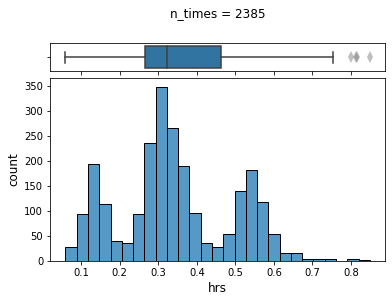

/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=2432 luni=2430
  warnings.warn(text)


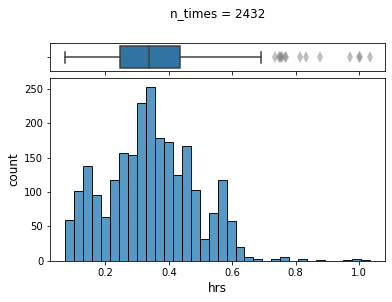

/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=2432 luni=2430
  warnings.warn(text)


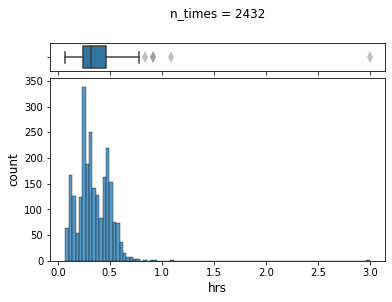

/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=2391 luni=2385
  warnings.warn(text)


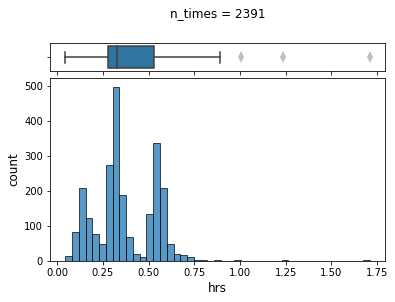

/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=2395 luni=2385
  warnings.warn(text)


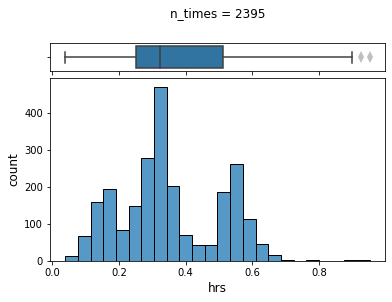

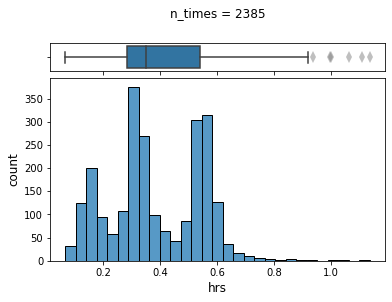

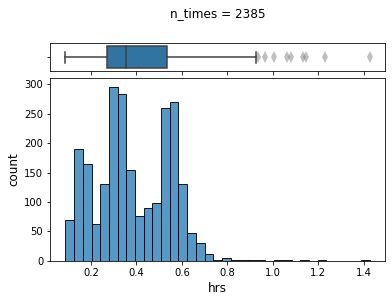

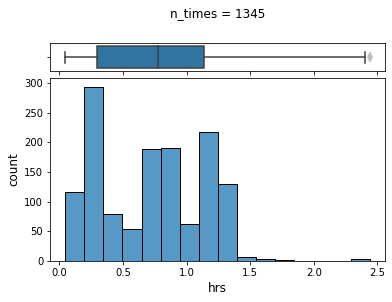

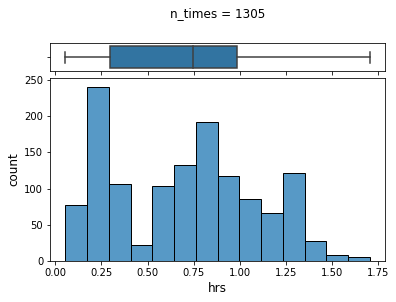

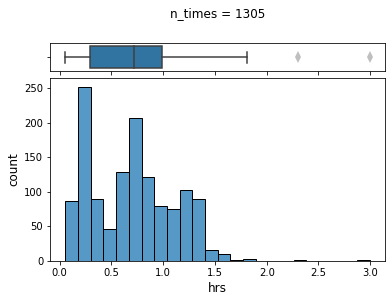

In [16]:
# see how long previous batch jobs have taken, increase time
for repdir in mvp.repdirs:
    shdir = f'{repdir}/lfmm2/lfmm_shfiles'
    pkl = f'{shdir}/batch_seffs.pkl'
    
    seffs = pklload(pkl)
    
    seffs.plot_times()

In [17]:
mvp_dir = '/home/b.lind/code/MVP-offsets/01_src'

shfiles = wrap_defaultdict(list, 2)
for (nuis_envs, seed), garden_files in unwrap_dictionary(new_envfiles, progress_bar=True):
    # get directories
    outerdir = nuis_outerdirs[nuis_envs]
    slimdir = f'{outerdir}/slimdir'
    mvp10.seed = seed
    indir, outdir, shdir = mvp10.make_lfmm_dirs(outerdir)
    for d in [outerdir, slimdir, indir, outdir, shdir]:
        assert op.exists(d)
    
    # name candidate loci files
    adaptive_file, neutral_file = sorted(
        fs(f'{outerdir}/lfmm2/lfmm_infiles', startswith=seed, endswith='loci.txt')
    )
    
    # how many envs?
    num_envs = 2 + len(nuis_envs.split('-'))  # sal + temp + nuis_envs
    
    # which envfile?
    lfmm_envfile = f'{outerdir}/lfmm2/lfmm_infiles/{seed}_lfmm_env_ntraits-{num_envs}.txt'
    assert op.exists(lfmm_envfile)
    
    # which pop file?
    poplabel_file = f'{outerdir}/lfmm2/lfmm_infiles/{seed}_poplabels.txt'
    
    # create lfmm commands
    jobcount = 0  # to know when I'm done iterating
    cmds = []  # list of training commands to parallelize for a given job
    for garden_file in garden_files:
        garden = op.basename(garden_file).split("_")[-1].split('.')[0]
        
        # for each marker set:
        for cand_file, marker_set in zip(['None', adaptive_file, neutral_file], ['all', 'adaptive', 'neutral']):
            output_file = op.join(outdir, f'{seed}_lfmm_offsets_ntraits-{num_envs}_{marker_set}_{garden}.txt')

            cmd = ' '.join(['Rscript',
                            f'{mvp_dir}/MVP_process_lfmm.R',
                            seed,
                            slimdir,
                            lfmm_envfile,
                            garden_file,
                            poplabel_file,
                            output_file,
                            cand_file])
            cmds.append(cmd)
            jobcount += 1
            
            if len(cmds) == 72 or jobcount == len(garden_files) * 3: # 3 hard coded for marker_sets (all nuet adptv)
                batch_num = str(len(shfiles[nuis_envs][seed])).zfill(2)
                job = f'{seed}_lfmm_batch_{batch_num}_{nuis_envs}'
                
                # write commands to a file that I can `cat` to GNU parallel
                cmd_file = op.join(indir, f'{job}.txt')
                with open(cmd_file, 'w') as o:
                    o.write('\n'.join(cmds))

                # where to write sh text
                shfile = op.join(shdir, f'{job}.sh')
                
                # what text to write to sh
                text = f'''#!/bin/bash
#SBATCH --job-name={job}
#SBATCH --time=6:00:00
#SBATCH --mem=180000M
#SBATCH --partition=short
#SBATCH --nodes=1
#SBATCH --cpus-per-task=36
#SBATCH --output={job}_%j.out
#SBATCH --mail-user=b.lind@northeastern.edu
#SBATCH --mail-type=FAIL

source $HOME/.bashrc  # assumed that conda init is within .bashrc

module load parallel

conda activate MVP_env_R4.0.3

# train lfmm2 and calculate offset
cat {cmd_file} | parallel -j 36 --progress --eta

conda activate mvp_env

cd {mvp_dir}

# re run any failed jobs from the cmd_file
python MVP_watch_for_failure_of_train_lfmm2_offset.py {seed} {shfile} {outerdir} 36

'''
                # write slurm script to file
                with open(shfile, 'w') as o:
                    o.write(text)
                shfiles[nuis_envs][seed].append(shfile)

                cmds = []  # reset

    

100%|███████████████| 2/2 [00:34<00:00, 17.30s/it]


In [18]:
# sanity check that all sh texts are unique
all_texts = []
for (nuis_envs, seed), batch_shfiles in unwrap_dictionary(shfiles):
    for f in batch_shfiles:
        text = read(f, lines=False)
        assert text not in all_texts
        all_texts.append(text)

# sbatch batch files and validation files

In [26]:
all_pids = defaultdict(list)
count = 0
for (nuis_envs, seed), batch_shfiles in unwrap_dictionary(shfiles):
    if nuis_envs == 'ISO-TSsd-PSsd':
        # only submit one nuis_env files (1125 jobs, max=1500 jobs)
        break
        
    print(count)
    
    # get some dirs
    outerdir = nuis_outerdirs[nuis_envs]
    shdir = f'{outerdir}/lfmm2/lfmm_shfiles'
    assert op.exists(shdir)
    
    # submit batch jobs
    pids = sbatch(batch_shfiles)
    
    # submit dependency job to run after all other jobs finish
    job = f'{seed}_lfmm_validation_{nuis_envs}'
    shtext = f"""#!/bin/bash
#SBATCH --job-name={job}
#SBATCH --time=3:00:00
#SBATCH --mem=4000
#SBATCH --partition=short
#SBATCH --nodes=1
#SBATCH --output={job}_%j.out
#SBATCH --mail-user=b.lind@northeastern.edu
#SBATCH --mail-type=FAIL
#SBATCH --dependency=afterok:{','.join(pids)}

source $HOME/.bashrc

conda activate mvp_env

cd {mvp_dir}

python MVP_11_validate_lfmm2_offset.py {seed} {slimdir} {outerdir}

"""
    shfile = op.join(shdir, f'{job}.sh')
    with open(shfile, 'w') as o:
        o.write(shtext)

    all_pids[nuis_envs].extend(
        sbatch(shfile, progress_bar=False)
    )
    
    count += 1
    clear_output(wait=True)

224


sbatching: 100%|███████████████| 5/5 [00:02<00:00,  2.04it/s]


In [29]:
count

225

In [28]:
# create watcher files to alert me when everything is done
for nuis_envs, pids in all_pids.items():
    outerdir = nuis_outerdirs[nuis_envs]
    shdir = f'{outerdir}/lfmm2/lfmm_shfiles'
    assert op.exists(shdir)
    
    create_watcherfile(pids,
                       shdir,
                       watcher_name=f'{nuis_envs}_lfmm_watcher',
                       end_alert=True)
    

['36971914']


In [30]:
outerdir = nuis_outerdirs['ISO-TSsd-PSsd']

pkl = f'{outerdir}/nuis_batch_shfiles.pkl'

pkldump(shfiles, pkl)

pkl

'/home/b.lind/offsets/run_20220919_nuisance/ISO-TSsd-PSsd_0-225/nuis_batch_shfiles.pkl'

# create named tuple for MVP_11

In [87]:
old_outerdir

'/home/b.lind/offsets/run_20220919_0-225'

In [90]:
# save arbitrary pkl
original_pkl = f'{old_outerdir}/pipeline_input_args_02-22-2023-09:01:56.pkl'

for nuis_env, outerdir in nuis_outerdirs.items():
    pkl = f'{outerdir}/pipeline_input_args.pkl'
    shutil.copy(original_pkl, pkl)
    

# submit ISO-TSsd-PSsd jobs

In [1]:
from pythonimports import *

import MVP_summary_functions as mvp
import MVP_10_train_lfmm2_offset as mvp10

run = '0-225'

nuis_outerdirs = {
    'ISO-PSsd' : f'/home/b.lind/offsets/run_20220919_nuisance/ISO-PSsd_{run}',
    'ISO-TSsd-PSsd' : f'/home/b.lind/offsets/run_20220919_nuisance/ISO-TSsd-PSsd_{run}'
}

lfmm_dirs = {}
for nuis_envs, outerdir in nuis_outerdirs.items():
    lfmm_dirs[nuis_envs] = makedir(f'{outerdir}/lfmm2')
    
old_outerdir = f'/home/b.lind/offsets/run_20220919_{run}'


mvp.latest_commit()
session_info.show()

#########################################################
Today:	June 23, 2023 - 09:00:56 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit eb8d204ff9a40e48b07c184bcc4ff8621804cde6  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu Jun 15 14:34:48 2023 -0400

Current commit of MVP_offsets:
commit 024290cb8c961841537c81afd1a02917b24bc9af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Jun 12 10:46:56 2023 -0400
#########################################################



In [2]:
shfiles = pklload('/home/b.lind/offsets/run_20220919_nuisance/ISO-TSsd-PSsd_0-225/nuis_batch_shfiles.pkl')

In [7]:
mvp_dir = '/home/b.lind/code/MVP-offsets/01_src'

all_pids = defaultdict(list)
count = 0
for (nuis_envs, seed), batch_shfiles in unwrap_dictionary(shfiles):
    if nuis_envs == 'ISO-PSsd':
        # only submit one nuis_env files (1125 jobs, max=1500 jobs)
        continue
        
    print(count)
    
    # get some dirs
    outerdir = nuis_outerdirs[nuis_envs]
    shdir = f'{outerdir}/lfmm2/lfmm_shfiles'
    slimdir = f'{outerdir}/slimdir'
    assert op.exists(shdir)
    
    # submit batch jobs
    pids = sbatch(batch_shfiles)
    
    # submit dependency job to run after all other jobs finish
    job = f'{seed}_lfmm_validation_{nuis_envs}'
    shtext = f"""#!/bin/bash
#SBATCH --job-name={job}
#SBATCH --time=3:00:00
#SBATCH --mem=4000
#SBATCH --partition=short
#SBATCH --nodes=1
#SBATCH --output={job}_%j.out
#SBATCH --mail-user=b.lind@northeastern.edu
#SBATCH --mail-type=FAIL
#SBATCH --dependency=afterok:{','.join(pids)}

source $HOME/.bashrc

conda activate mvp_env

cd {mvp_dir}

python MVP_11_validate_lfmm2_offset.py {seed} {slimdir} {outerdir}

"""
    shfile = op.join(shdir, f'{job}.sh')
    with open(shfile, 'w') as o:
        o.write(shtext)

    all_pids[nuis_envs].extend(
        sbatch(shfile, progress_bar=False)
    )
    
    count += 1
    clear_output(wait=True)

224


sbatching: 100%|███████████████| 5/5 [00:01<00:00,  4.19it/s]


In [10]:
count

225

In [8]:
Squeue()

🗒️  Queue Summary:

{'lotterhos': {'R': 1},
 'short': {'PD': 1326, 'R': 26}}

In [11]:
Squeue(exclude=['bash', 'validation'])

🗒️  Queue Summary:

{'short': {'PD': 1100, 'R': 26}}

In [12]:
Squeue(exclude=['bash', 'validation'], partition='short').update(to_partition='long', num_jobs=0.5)

update: 100%|███████████████| 550/550 [00:28<00:00, 19.06it/s]


In [13]:
Squeue(exclude=['bash', 'validation'], partition='short').update(to_partition='lotterhos', num_jobs=50)

update: 100%|███████████████| 50/50 [00:03<00:00, 15.78it/s]


In [16]:
Squeue().watch()

🗒️  Queue Summary:

{'long': {'PD': 545, 'R': 5},
 'lotterhos': {'PD': 49, 'R': 2},
 'short': {'PD': 724, 'R': 28}}


sleeping:  20%|███            | 1/5 [00:01<00:05,  1.46s/it]

KeyboardInterrupt after 1 seconds of sleep.


In [19]:
Squeue()

🗒️  Queue Summary:

{'long': {'PD': 507, 'R': 25},
 'lotterhos': {'PD': 49, 'R': 2},
 'short': {'PD': 702, 'R': 28}}